# Exploring Kinoeva Data

Reference: https://python-graph-gallery.com/

# **Ensure `utils.py` file is within the content folder first before continuing**

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# style
sns.set()

from utils import read_kinoeva
%matplotlib inline

In [88]:
# If running from colab
!git clone https://github.com/nicholashojunhui/hss

fatal: destination path 'hss' already exists and is not an empty directory.


In [89]:
df = read_kinoeva('/content/hss/data/2/CFF Demo_ Underhand Vertical Med Ball Throw.txt')
df.head()

,X,Y,Original_timestamp
T,,,
0 days 00:00:00,0.0,0.0,0:00:00:00
0 days 00:00:00.030000,1.0,9.0,0:00:00:03
0 days 00:00:00.060000,2.0,20.0,0:00:00:06
0 days 00:00:00.100000,3.0,34.0,0:00:00:10
0 days 00:00:00.130000,5.0,48.0,0:00:00:13


In [90]:
# We can do two time series plots
# Adapting this example: https://python-graph-gallery.com/122-multiple-lines-chart/

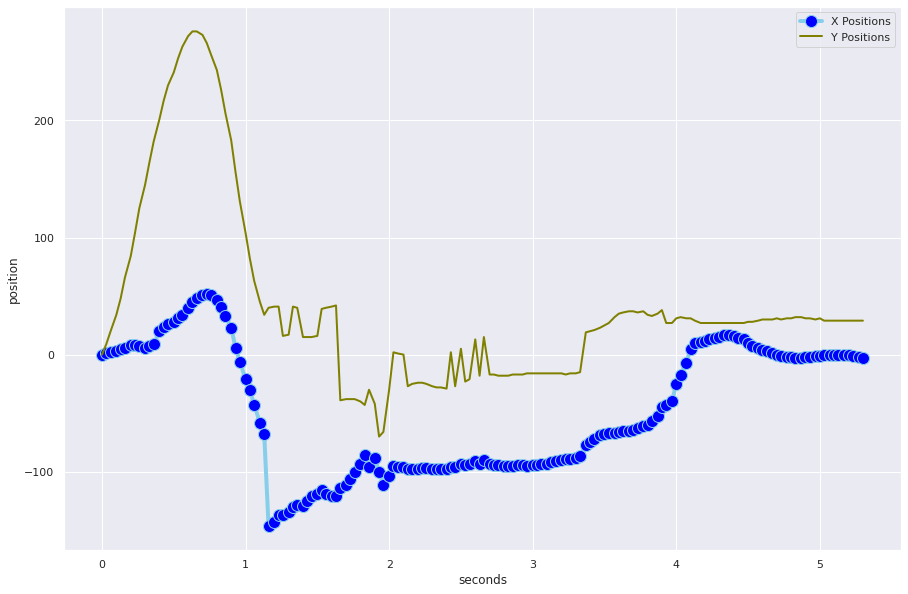

In [91]:
fig, ax = plt.subplots(figsize=(15, 10))

# convert to seconds
timestamps = df.index.values / np.timedelta64(1, 's')

# plot both series
ax.plot(timestamps, df.X, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
ax.plot(timestamps, df.Y, marker='', color='olive', linewidth=2)
ax.set_xlabel('seconds')
ax.set_ylabel('position')

ax.legend(labels=['X Positions', 'Y Positions'])
plt.show()

# Multiple Trajectories

The example above shows a single trajectory (ball).  

Next, let's explore multiple trajectories, with the final goal of modeling relationships between them.
- Throw 1: ball and hips trajectories
- Throw 2: ball and hips trajectories

Notes:
- Kinovea saves all trajectories to 1 big text file. The multiple text files are then created by manually splitting into separate files.
- The trajectories are tracked in a way that aligns the timestamps.

In [92]:
df_ball1 = read_kinoeva('/content/hss/data/3/CFF Demo_ Underhand Vertical Med Ball Throw1_Ball.txt')
df_ball1.head()

,X,Y,Original_timestamp
T,,,
0 days 00:00:00,155.0,42.0,0:00:00:00
0 days 00:00:00.030000,155.0,47.0,0:00:00:03
0 days 00:00:00.060000,156.0,53.0,0:00:00:06
0 days 00:00:00.100000,157.0,62.0,0:00:00:10
0 days 00:00:00.130000,158.0,74.0,0:00:00:13


In [93]:
df_hips1 = read_kinoeva('/content/hss/data/3/CFF Demo_ Underhand Vertical Med Ball Throw1_Hips.txt')
df_hips1.head()

,X,Y,Original_timestamp
T,,,
0 days 00:00:00,-25.0,199.0,0:00:00:00
0 days 00:00:00.030000,-25.0,201.0,0:00:00:03
0 days 00:00:00.060000,-25.0,204.0,0:00:00:06
0 days 00:00:00.100000,-24.0,207.0,0:00:00:10
0 days 00:00:00.130000,-24.0,211.0,0:00:00:13


In [94]:
df_ball2 = read_kinoeva('/content/hss/data/3/CFF Demo_ Underhand Vertical Med Ball Throw2_Ball.txt')
df_ball2.head()

,X,Y,Original_timestamp
T,,,
0 days 00:00:00,255.0,96.0,0:00:00:00
0 days 00:00:00.030000,258.0,104.0,0:00:00:03
0 days 00:00:00.060000,261.0,116.0,0:00:00:06
0 days 00:00:00.100000,266.0,129.0,0:00:00:10
0 days 00:00:00.130000,271.0,140.0,0:00:00:13


In [95]:
df_hips2 = read_kinoeva('/content/hss/data/3/CFF Demo_ Underhand Vertical Med Ball Throw2_Hips.txt')
df_hips2.head()

,X,Y,Original_timestamp
T,,,
0 days 00:00:00,116.0,263.0,0:00:00:00
0 days 00:00:00.030000,115.0,265.0,0:00:00:03
0 days 00:00:00.060000,115.0,267.0,0:00:00:06
0 days 00:00:00.100000,115.0,269.0,0:00:00:10
0 days 00:00:00.130000,116.0,271.0,0:00:00:13


In [96]:
def plot_positions(ax, df, title):
    timestamps = df.index.values / np.timedelta64(1, 's')

    ax.set_title(title)
    ax.plot(timestamps, df.X, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    ax.plot(timestamps, df.Y, marker='', color='olive', linewidth=2)
    ax.set_xlabel('seconds')
    ax.set_ylabel('position')
    ax.legend(labels=['X Positions', 'Y Positions'])

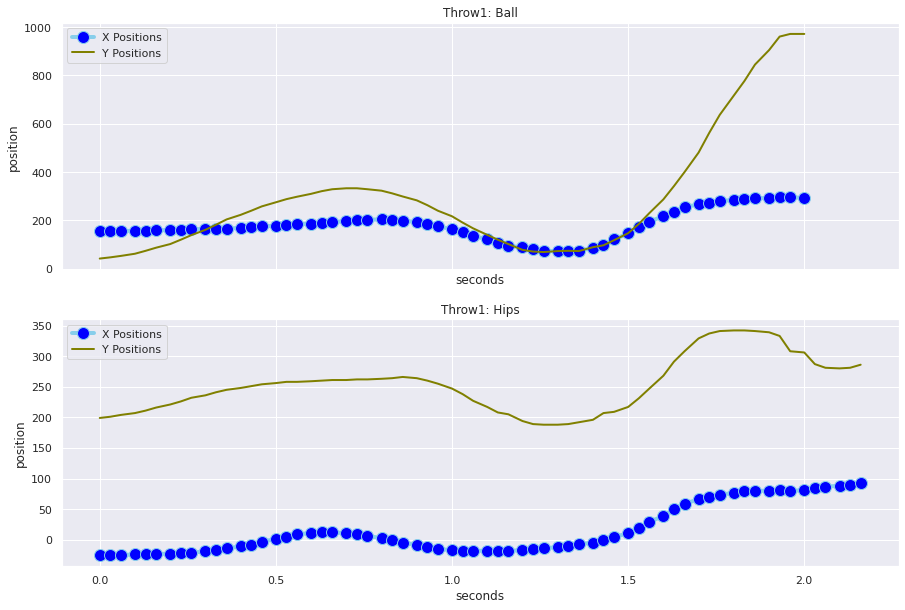

In [97]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
plot_positions(ax0, df_ball1, 'Throw1: Ball')
plot_positions(ax1, df_hips1, 'Throw1: Hips')
plt.show()

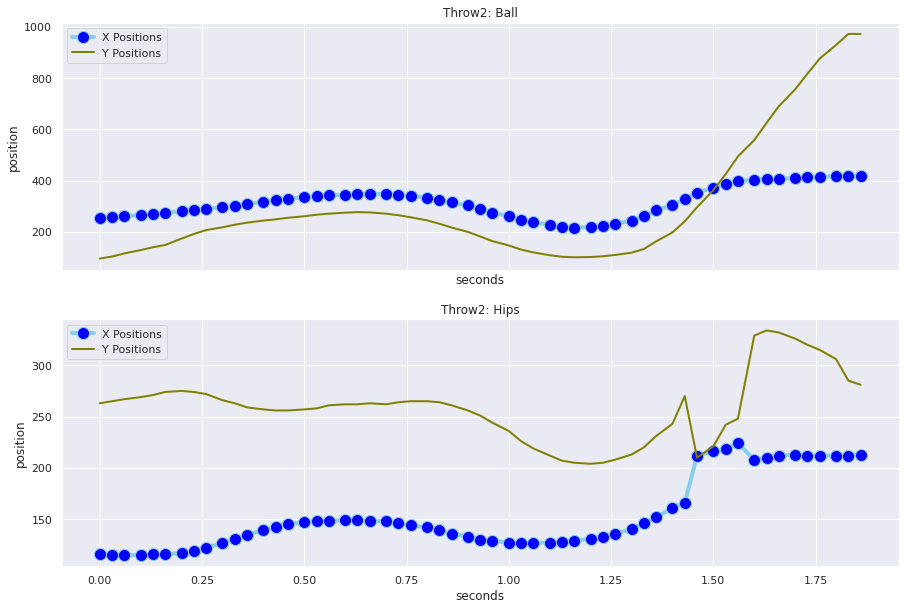

In [98]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
plot_positions(ax0, df_ball2, 'Throw2: Ball')
plot_positions(ax1, df_hips2, 'Throw2: Hips')
plt.show()

# Velocity and Acceleration

References:
- https://dsp.stackexchange.com/questions/9498/have-position-want-to-calculate-velocity-and-acceleration
- https://stackoverflow.com/questions/16841729/how-do-i-compute-the-derivative-of-an-array-in-python

In [99]:
from numpy import diff

def velocity_and_acceleration(df:pd.DataFrame):
    """
    Args:
        df: Dataframe with the following information
            index: timedelta
            X: x-coordinate
            Y: y-coordinate
    Returns:
        Dictionary with the following keys and values:
            vx: x-velocity
            vy: y-velocity
            ax: x-acceleration
            ay: y-acceleration
    """
    t = df.index.values / np.timedelta64(1, 's')
    x = df.X.values
    y = df.Y.values

    dt = diff(t.astype('float'))
    dx = diff(x)
    vx = dx/dt

    dy = diff(y)
    vy = dy/dt
    
    ax = diff(vx)/dt[1:]
    ay = diff(vy)/dt[1:]
    
    return {'t': t, 'vx': vx, 'vy': vy, 'ax': ax, 'ay': ay}

In [100]:
va_ball1 = velocity_and_acceleration(df_ball1)
va_hips1 = velocity_and_acceleration(df_hips1)

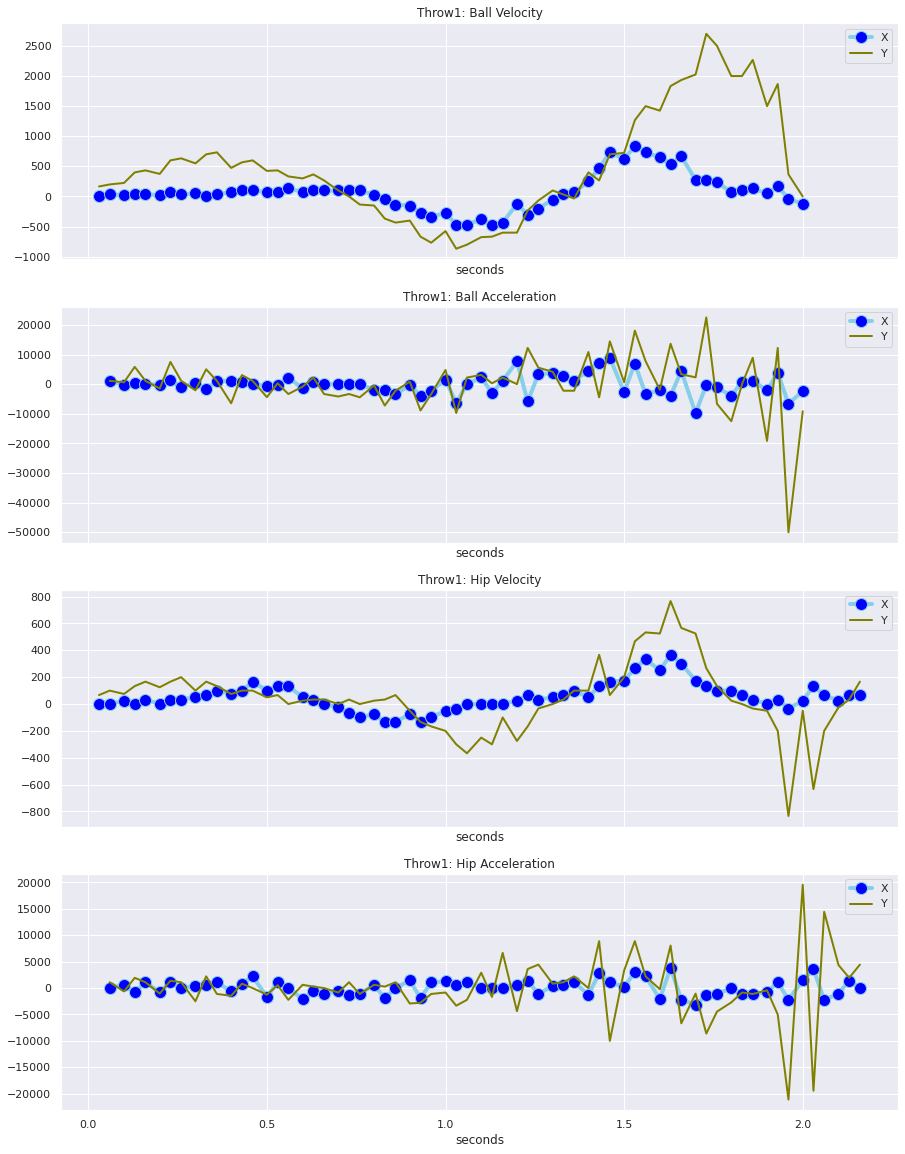

In [101]:
def plot_series(ax, title, t, x, y):
    ax.set_title(title)
    ax.plot(t, x, label='X', marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    ax.plot(t, y, label='Y', marker='', color='olive', linewidth=2)
    ax.set_xlabel('seconds')
    ax.legend()
        
fig, [ax0, ax1, ax2, ax3] = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# drop the first time value (velocity is a first order difference)
plot_series(ax0, 'Throw1: Ball Velocity', va_ball1['t'][1:], va_ball1['vx'], va_ball1['vy'])

# drop the first two time values (acceleration is a 2nd order difference)
plot_series(ax1, 'Throw1: Ball Acceleration', va_ball1['t'][2:], va_ball1['ax'], va_ball1['ay'])

plot_series(ax2, 'Throw1: Hip Velocity', va_hips1['t'][1:], va_hips1['vx'], va_hips1['vy'])

plot_series(ax3, 'Throw1: Hip Acceleration', va_hips1['t'][2:], va_hips1['ax'], va_hips1['ay'])

plt.show()

# Cross correlation

https://en.wikipedia.org/wiki/Cross-correlation

https://matplotlib.org/gallery/lines_bars_and_markers/xcorr_acorr_demo.html

In [102]:
len(va_hips1['vx'])

65

In [103]:
# different length from above
len(va_ball1['vx'])

60

In [104]:
# make sure the series are the same lengths
n = min(len(va_ball1['vx']), len(va_hips1['vx']))

vb = va_ball1['vx'][:n]
vh = va_hips1['vx'][:n]

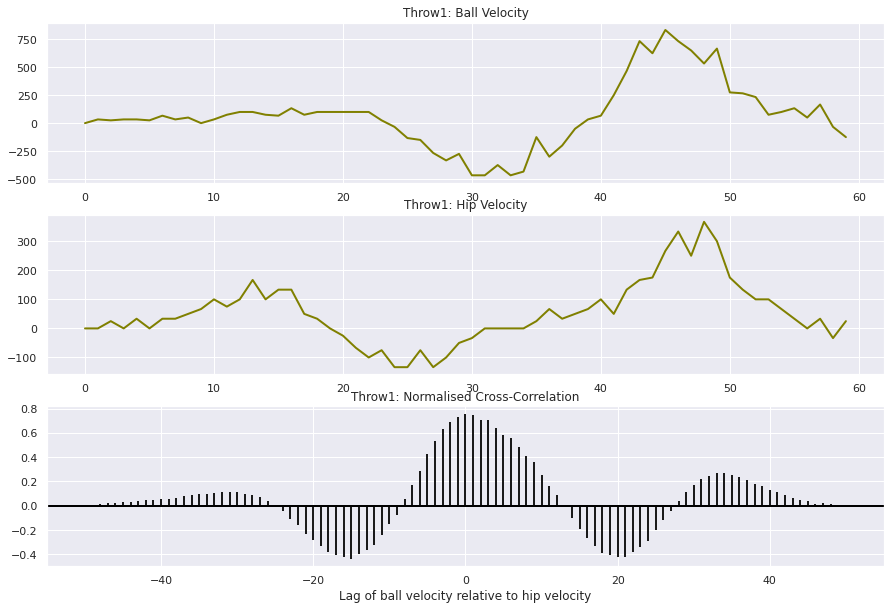

In [105]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

axs[0].set_title('Throw1: Ball Velocity')
axs[0].plot(vb, marker='', color='olive', linewidth=2)

axs[1].set_title('Throw1: Hip Velocity')
axs[1].plot(vh, marker='', color='olive', linewidth=2)

axs[2].set_title('Throw1: Normalised Cross-Correlation')
axs[2].set_xlabel('Lag of ball velocity relative to hip velocity')
axs[2].xcorr(vb, vh, usevlines=True, maxlags=50, normed=True, lw=2)
axs[2].axhline(0, color='black', lw=2)

plt.show()

# Simple Regression (non-time-series)

Can we predict ball velocity based on hip velocity?

In [106]:
X = vh
target = vb

# shuffle, train test split
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.2)

In [107]:
# scaler
X_scaler = StandardScaler()
X_train_sc = X_scaler.fit_transform(X_train.reshape(-1, 1))
X_test_sc = X_scaler.transform(X_test.reshape(-1, 1))

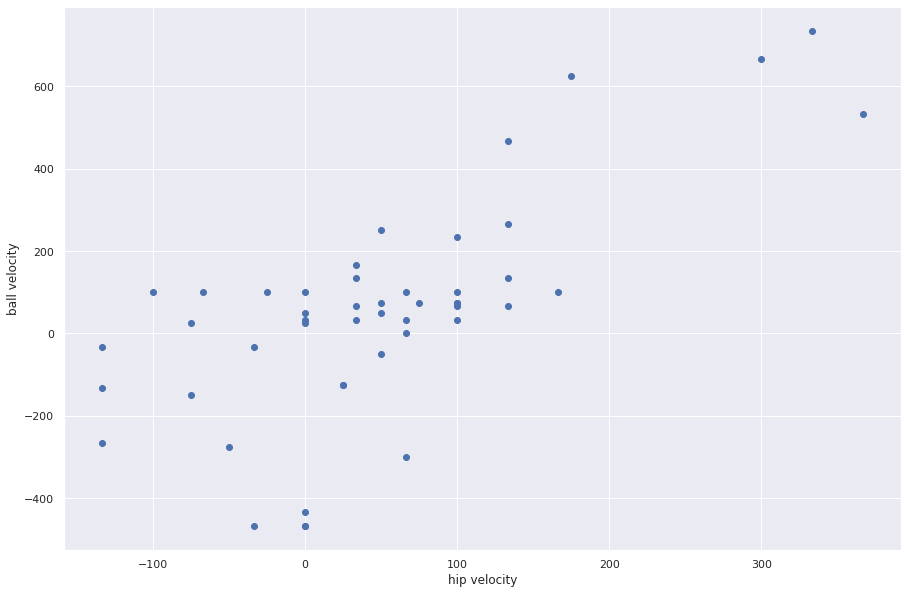

In [108]:
# plot X_train vs. target_train

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_train, target_train)
ax.set_xlabel('hip velocity')
ax.set_ylabel('ball velocity')
plt.show()

In [109]:
lin = LinearRegression()
lin.fit(X_train_sc, target_train)

print(lin.coef_, lin.intercept_) # fitted coefficients and intercept
print(lin.score(X_test_sc, target_test)) # r2 score

[183.56377103] 49.30555555555558
0.634027771508591


In [110]:
# Linear Regression with Polynomial Features
poly = PolynomialFeatures()
X_scaler_p = StandardScaler()

# generate polynomial features (2 degree)
X_train_p = poly.fit_transform(X_train.reshape(-1, 1))
X_test_p = poly.transform(X_test.reshape(-1, 1))

# scale polynomials
X_train_p_sc = X_scaler_p.fit_transform(X_train_p)
X_test_p_sc = X_scaler_p.transform(X_test_p)

# fit model
lin_p = LinearRegression()
lin_p.fit(X_train_p_sc, target_train)
print(lin_p.coef_, lin_p.intercept_)
lin_p.score(X_test_p_sc, target_test)

[  0.         128.65177476  74.68761404] 49.305555555555564


0.6432388306017568

In [111]:
pred_p_train = lin_p.predict(X_train_p_sc)
pred_p_test = lin_p.predict(X_test_p_sc)

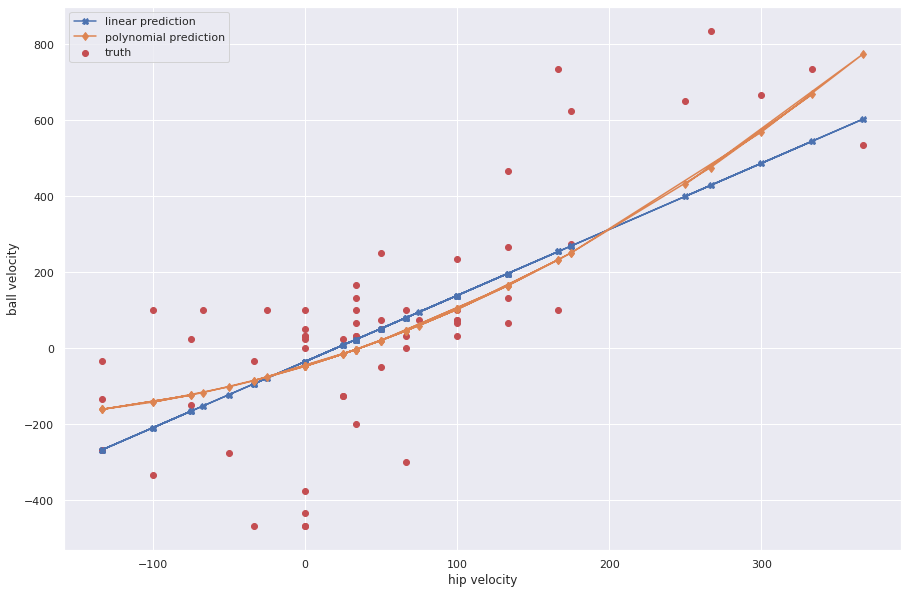

In [113]:
# Plot predictions vs. target

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, target, marker='o', label='truth', color='r')

pred = lin.predict(X_scaler.transform(X.reshape(-1, 1)))
ax.plot(X, pred, label='linear prediction', marker='X')

pred_p = lin_p.predict(X_scaler_p.transform(poly.transform(X.reshape(-1, 1))))
ax.plot(X, pred_p, label='polynomial prediction', marker='d')

ax.set_xlabel('hip velocity')
ax.set_ylabel('ball velocity')
ax.legend()
plt.show()